___
# Projeto 3 - CD
___

## Regressão logística que agrupa músicas com diferentes tipos de tons e de notas musicais, relacionando com o quão dançável é a música.

    Imagine que você é um músico e quer compor uma música, porém quer que ela seja calma e que esteja no Spotify, qual a probabilidade de você usar o tom menor e qual nota provavelmente você usaria? 
    O objetivo desse projeto é responder esta pergunta prevendo qual seria a decisão que você, provavelmente, tomaria nesta situação. Para isso, devemos utilizar a regressão logística, pois estamos relacionando uma variável categórica com uma contínua. Ou seja, estamos relacionando as notas musicais e o tom (juntamente a elas) com o quão dançável é a música, fazendo uma comparação, também, com o quão energética é a música.

Exemplo de aplicação da técnica: https://www.kaggle.com/noemir/dimension-reduction-of-music-pref-in-progress/comments 

**Nomes das integrantes:**
Rebeca Moreno,
Giulia Passarelli e
Carla Kim

## Parte 1: Dicionário dos Dados

In [1]:
from IPython.display import Image
Image(filename=('/Users/RebecaMoreno/Desktop/dic.png'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/RebecaMoreno/Desktop/dic.png'

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import expon
import seaborn as sns
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

In [7]:
#lendo a planilha de dados
sptdata = pd.read_csv("data.csv")

#ajustando a quantidade de termos que precisamos usar
spotdata = sptdata[0:500]
spotdatatreina = sptdata[500:1000]


## Parte 2: Discretizando dados

C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

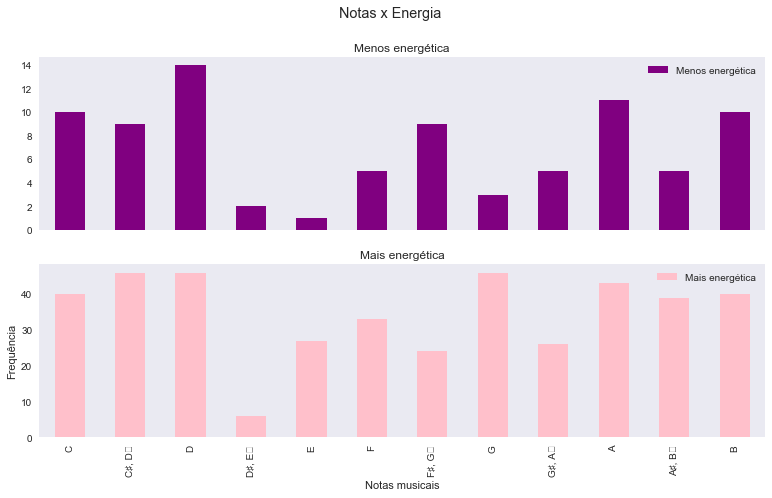

In [8]:
#criando uma nova coluna somente para o KEY CATEGÓRICO, ou seja, só com as notas (strings)
spotdata['notakey'] = spotdata.key
spotdata['notakey'] = spotdata['notakey'].astype('category')
l = ['C','C♯, D♭','D','D♯, E♭','E','F','F♯, G♭','G','G♯, A♭','A','A♯, B♭','B']
spotdata['notakey'].cat.categories = (l)
#criando uma nova coluna somente para o ENERGY CATEGÓRICO, ou seja, só com dois grupos (strings)
spotdata['energyy'] = spotdata['energy']
#filtrando...
spotdata.energyy[(spotdata.energyy >= 0) & (spotdata.energyy < 0.5)] = [0]
spotdata.energyy[(spotdata.energyy >= 0.5) & (spotdata.energyy < 1)] = [1]
spotdata.energyy = spotdata.energyy.astype('category')
spotdata.energyy.cat.categories = (['Menos energética','Mais energética'])
#criando uma nova coluna somente para o MODE CATEGÓRICO, ou seja, só com os dois grupos (strings)
df = pd.DataFrame()
spotdata['tom'] = spotdata['mode']
spotdata['tom'] = spotdata.tom.astype('category')
spotdata.tom.cat.categories = (['Menor','Maior'])

#tabela de notas por energy
NotaEnergy = pd.crosstab(spotdata.notakey,spotdata.energyy, colnames=['Grau de energia'],rownames=['Notas musicais'])
NotaEnergy.plot(kind = 'bar',title = 'Notas x Energia',figsize=(13,7),color = ('purple','pink'),grid=False,subplots=True)
plt.ylabel('Frequência')
plt.show()

    Neste gráfico, podemos observar que, nesta lista de 100 músicas, são tocadas mais músicas energéticas do que o contrário, pois a quantidade de dados com a cor rosa é maior que a da cor roxa. Lenvando isso para o nosso contexto, você teria menor possibilidade de ser aceito, fazendo uma música mais calma (menos energética).
    Observamos também que a nota C#/D, por exemplo, tem uma tendência de ser tocada em músicas mais energéticas, enquanto que a nota mais frequente em músicas depressivas é a D. Portanto, no seu caso, para você fazer uma música menos elétrica, sendo ela aceita pelo Spotify, a probabilidade que se use a nota D é 6%, enquanto que a nota C#/D é 4%, por exemplo.

In [9]:
#tabela de  frequência das notas em cada tipo de tom
ut2 = pd.crosstab(spotdata.notakey,spotdata.tom, colnames=['Tom'], rownames=['Notas Musicais'], margins=True)
ut2

Tom,Menor,Maior,All
Notas Musicais,,,
C,10,40,50
"C♯, D♭",17,38,55
D,13,47,60
"D♯, E♭",3,5,8
E,18,10,28
F,25,13,38
"F♯, G♭",14,19,33
G,11,38,49
"G♯, A♭",10,21,31


    Nesta tabela, vemos, não só a frequência de cada nota dentro das 100 músicas, como também a quantidade de vezes que esta nota foi usada em músicas com tom maior e menor. 
    Nela, vemos que, em músicas com tom maior, são frequentemente usadas as notas: D, C#/D e C. 
    Em contrapartida, em músicas com tom menor, são frequentemente usadas as notas: B, A#/B e F.   
    

C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

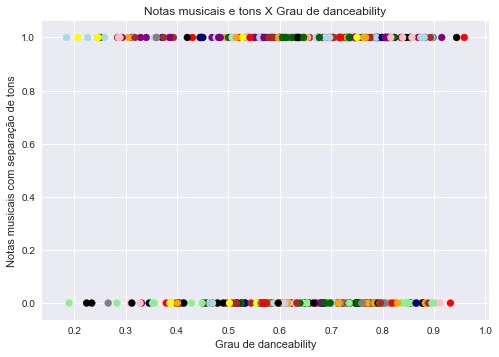

In [19]:
#para o treinamento do computador dos 100 primeiros termos
spotdata['mode12key'] = spotdata['mode']*12 + spotdata['key']
spotdata['mode12key'] = np.where(spotdata.mode12key >= spotdata['mode12key'].mean(), 1, 0)
#para o teste dos novos termos de 100 a 200
spotdata['mode12keytreina'] = spotdatatreina['mode']*12 + spotdatatreina['key']
spotdata['mode12keytreina'] = np.where(spotdata.mode12keytreina >= spotdata['mode12keytreina'].mean(), 1, 0)

spotdata["notas"] = spotdata["key"]    
spotdata['notas'] = spotdata['notas'].map({0: "C", 1: "C♯, D♭", 2: "D", 3: "D♯, E♭", 4: "E", 5: "F", 6: "F♯, G♭", 7: "G", 8: "G♯, A♭", 9: "A", 10: "A♯, B♭", 11: "B"})

#plot do gráfico 
fig, ax = plt.subplots()
colors = {'C':'lightgreen', 'C♯, D♭':'darkgreen', 'D':'lightblue', 'D♯, E♭':'darkblue', 'E':'yellow', 'F':'orange', 'F♯, G♭':'pink', 'G':'purple', 'G♯, A♭':'red', 'A':'brown', 'A♯, B♭':'gray', 'B':'black'}
ax.scatter(spotdata['danceability'], spotdata['mode12key'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Notas musicais e tons X Grau de danceability')
plt.ylabel('Notas musicais com separação de tons')
plt.xlabel('Grau de danceability')
plt.show()

## Parte 3: Gráfico da regressão

In [11]:
# fit a logistic regression model and store the class predictions
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
feature_cols = ['danceability']
X = spotdata[feature_cols]
y = spotdata['mode12key']
logreg.fit(X, y)
spotdata['mode12key_pred_class'] = logreg.predict(X)

C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


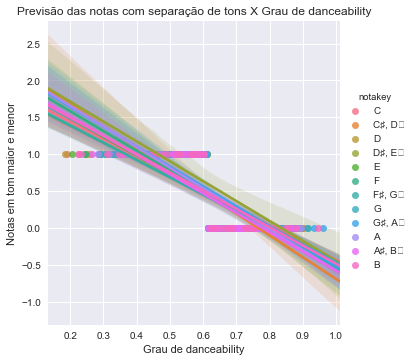

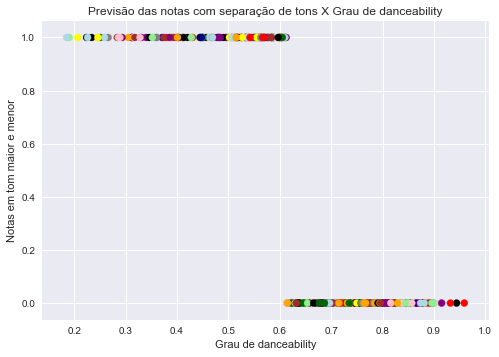

In [21]:
g = sns.lmplot(x="danceability", y="mode12key_pred_class", hue="notakey", data=spotdata,size=5)
plt.title('Previsão das notas com separação de tons X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Notas em tom maior e menor')
#gráfico dos dois grupos de tons (maior e menor) das notas de cada música por danceability
fig, ax = plt.subplots(1)
ax.scatter(spotdata['danceability'], spotdata['mode12key_pred_class'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Previsão das notas com separação de tons X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Notas em tom maior e menor')
plt.show()

    Os dois gráficos indicam uma previsão das notas e dos tons (juntamente a elas) com relação ao daceability. De forma que, no primeiro gráfico, são feitas regressões logísticas para cada nota musical, entretanto não é possível enxergar de maneira clara. Por isso, construímos o segundo gráfico, o qual tem a mesma finalidade do primeiro, porém sem as retas de regressão. Nele, observamos que músicas menos dançantes possuem maior probabilidade de utilizarem tons menores.

    Para enxergarmos claramente as regressões do primeiro gráfico, construímos 12 gráficos, em que cada um representa a regressão logística de uma determinada nota musical.

GRÁFICOS DE REGRESSÃO LOGÍSTICA DE CADA NOTA POR GRAU DE DANCEABILITY


Regressão logística das notas com separação de tons X Grau de danceability


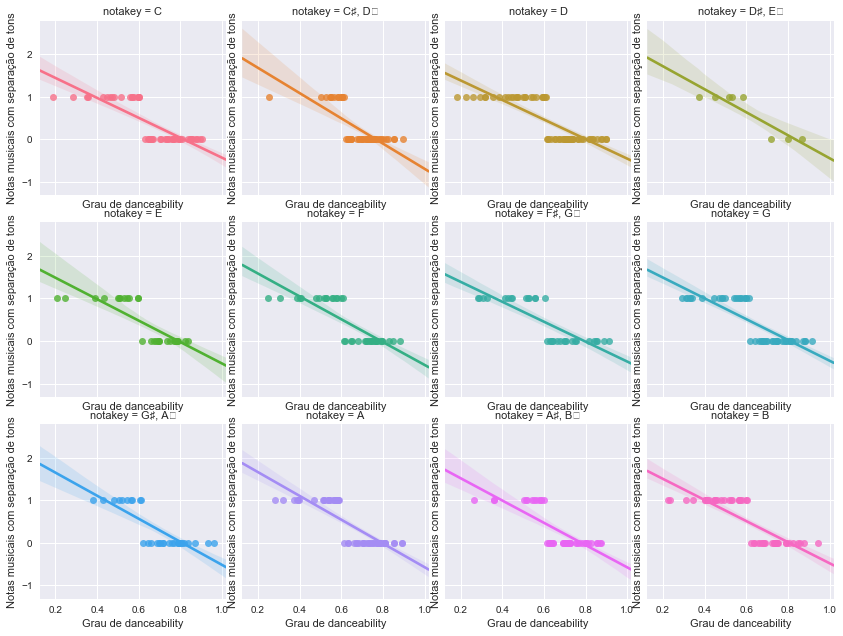

In [44]:
#gráfico da regressão logística das notas de cada música baseada em danceability
print('GRÁFICOS DE REGRESSÃO LOGÍSTICA DE CADA NOTA POR GRAU DE DANCEABILITY\n\n')
print('Regressão logística das notas com separação de tons X Grau de danceability')
a = sns.lmplot(x="danceability", y="mode12key_pred_class", col="notakey", hue="notakey",data=spotdata, col_wrap=4, size=3)
a.set(xlabel = "Grau de danceability", ylabel = "Notas musicais com separação de tons")
plt.show()

    A reta representa a regressão logística da nota musical juntamente com a diferença no tipo de tom por danceability. A "mancha" mais clara que há em algumas regressões nos diz que, como temos poucos pontos do gráfico, há uma margem de erro, representada por essa "mancha".
    Conseguimos ver, também, a quantidade de cada nota em tom maior e menor por cada grau de danceability.

## Parte 4: Gráfico de probabilidade e exemplos

C:\Users\gb_pa\Documents\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


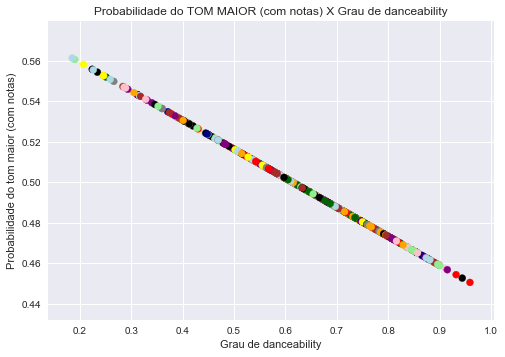

In [45]:
#gráfico da probabilidade por danceability
spotdata['mode12key_pred_prob'] = logreg.predict_proba(X)[:, 1]

fig, ax = plt.subplots()
ax.scatter(spotdata['danceability'], spotdata['mode12key_pred_prob'], c=spotdata['notas'].apply(lambda x: colors[x]))
plt.title('Probabilidade do TOM MAIOR (com notas) X Grau de danceability')
plt.xlabel('Grau de danceability')
plt.ylabel('Probabilidade do tom maior (com notas)')
plt.show()

    O gráfico acima comprova que, para dançabilidades baixas, é mais provável que o tom da música seja mais baixo e vice-versa.

In [15]:
# alguns exemplos de previsões
print('Exemplos de Probabilidades\n')
print('   Tom menor  |  Tom maior')

grau_de_danceability1 = 0.2
grau_de_danceability2 = 0.5
grau_de_danceability3 = 0.8

print(logreg.predict_proba(grau_de_danceability1))
print(logreg.predict_proba(grau_de_danceability2))
print(logreg.predict_proba(grau_de_danceability3))

Exemplos de Probabilidades

   Tom menor  |  Tom maior
[[ 0.44092688  0.55907312]]
[[ 0.48370633  0.51629367]]
[[ 0.52672592  0.47327408]]


    A primeira coluna diz respeito ao grupo de notas com o tom menor, mostrando a exata chance de se ter, por exemplo, um grau de danceability de 0.2 com o tom menor. Neste caso, a probabilidade de se ter tal danceability com tom menor é de 67,173525 %. Enquanto que, na segunda coluna, temos as mesmas informações, porém referentes ao grupo de notas com tom maior.
    Como, no caso, queremos achar a probabilidade de usarmos tom menor em uma música calma, ou seja, com um grau de danceability baixo, podemos assumir um limite de 0 a 0.5 deste grau para acharmos tal probabilidade.

In [16]:
grau_de_danceability4 = 0
grau_de_danceability5 = 0.5
print('   Tom menor  |  Tom maior')
print(logreg.predict_proba(grau_de_danceability4))
print(logreg.predict_proba(grau_de_danceability5))

   Tom menor  |  Tom maior
[[ 0.41284817  0.58715183]]
[[ 0.48370633  0.51629367]]


    Portanto, a probabilidade de se usar tom menor em uma música calma (grau de danceability de 0 a 0.5) é de 74,182825 % até 55,153401 %. Vemos que, quanto menos dançante é a música (quanto mais próximo de 0 é o grau de danceability), maior é a probabilidade de se usar o tom menor nas músicas. 

In [17]:
spotdata['danceability'].value_counts()

0.735    6
0.704    6
0.646    5
0.698    5
0.683    4
0.760    4
0.614    4
0.736    4
0.633    4
0.791    4
0.597    4
0.697    4
0.700    3
0.753    3
0.747    3
0.603    3
0.857    3
0.716    3
0.648    3
0.715    3
0.746    3
0.586    3
0.731    3
0.542    3
0.767    3
0.763    3
0.525    3
0.654    3
0.706    3
0.507    2
        ..
0.872    1
0.754    1
0.527    1
0.554    1
0.661    1
0.403    1
0.294    1
0.855    1
0.428    1
0.806    1
0.645    1
0.631    1
0.328    1
0.576    1
0.757    1
0.284    1
0.318    1
0.479    1
0.837    1
0.732    1
0.878    1
0.386    1
0.415    1
0.544    1
0.483    1
0.468    1
0.764    1
0.898    1
0.562    1
0.500    1
Name: danceability, dtype: int64

In [18]:
proximidade = 0.05
dance = 0.603
dances_ao_redor=[]
notas_ao_redor = []
notas_ao_redor2 = []
contador = 0
ln = []
d = np.arange(0,1,0.001)

dance_nota = {}

for i in range(len(spotdata)):
    for k in range(100):
        if dance+d[k] == spotdata['danceability'][i]:
            dances_ao_redor.append(spotdata['danceability'][i])
            notas_ao_redor.append(spotdata['notakey'][i])
            #0.630,0.637 
            #A,[C,B]
            dance_nota[spotdata['danceability'][i]]  = spotdata['notakey'][i]
#         elif dance-d[k] == spotdata['danceability'][i]:
            
    if spotdata['danceability'][i] in dance_nota:
        #se este ponto (danceability) já estiver no dicionário
        notas_ao_redor2[spotdata['danceability'][i]] = 
        
        
        dance_nota[spotdata['danceability'][i]][0] = dance_nota[spotdata['danceability'][i]]

print(dance_nota,sorted(dances_ao_redor))
#         print(spotdata['danceability'][i])
#         if spotdata['danceability'][i] >= dance+proximidade and spotdata['danceability'][i]<= dance-proximidade:
#             print(spotdata['danceability'][i])

SyntaxError: invalid syntax (<ipython-input-18-c10043b5fdf9>, line 24)

In [ ]:
proximidade = 0.05
dance = 0.603
dances_ao_redor=[]
notas_ao_redor = []
contador = 0
ln = []
d = np.arange(0,1,0.001)


for i in range(len(spotdata)):
    for k in range(100):
        if dance+d[k] == spotdata['danceability'][i]:
#             print(spotdata['danceability'][i])
#             print(spotdata['notakey'][i])
            dances_ao_redor.append(spotdata['danceability'][i])
            notas_ao_redor.append(spotdata['notakey'][i])
#             dance_nota[spotdata['danceability'][i]]  = spotdata['notakey'][i]
#     if spotdata['danceability'][i] in dance_nota:


print(notas_ao_redor,dances_ao_redor)
#         print(spotdata['danceability'][i])
#         if spotdata['danceability'][i] >= dance+proximidade and spotdata['danceability'][i]<= dance-proximidade:
#             print(spotdata['danceability'][i])

## Parte 4: Realizando a regressão e Encontrando o beta

In [ ]:
#train_cols = spotdata.columns[1:]

logit = sm.Logit(spotdata['danceability'], spotdata['mode12key_pred_class'])
result = logit.fit()
print(result)

logit2 = sm.Logit(spotdata['danceability'], spotdata['mode12key'])
result2 = logit2.fit()
print(result2)

logit3 = sm.Logit(spotdata['danceability'], spotdata['energy'])
result3 = logit3.fit()
print(result3)

#logit4 = sm.Logit(spotdata['danceability'], spotdata['k'])
#result4 = logit4.fit()
#print(result4)

In [ ]:
print (result.summary())
print (result2.summary())
print (result3.summary())

In [ ]:
print (result.conf_int())
print (result2.conf_int())
print (result3.conf_int())

In [ ]:
print (np.exp(result.params))
print (np.exp(result2.params))
print (np.exp(result3.params))

In [ ]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf))

In [ ]:
params = result2.params
conf2 = result2.conf_int()
conf2['OR'] = params
conf2.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf2))

In [ ]:
params = result3.params
conf3 = result3.conf_int()
conf3['OR'] = params
conf3.columns = ['2.5%', '97.5%', 'OR']
print (np.exp(conf3))

In [ ]:
dummy_ranks = pd.get_dummies(spotdata['energy'], prefix='energy')
print (dummy_ranks.head())
#trasnformar energy em binarios, ou seja, eh energetico ou nao

In [ ]:
cols_to_keep = ['mode','danceability', 'mode12key']
dataff = spotdata[cols_to_keep].join(dummy_ranks.ix[:, 'energy_0':])
print (dataff.head())
#ordenando as informaoes, com o MODE, tom, como a variavel que queremos descobrir

In [ ]:
dataff['intercept'] = 1.0

In [ ]:
import statsmodels.api as sm
train_cols = dataff.columns[1:]
logitt = sm.Logit(dataff['mode'], dataff[train_cols])
resultt = logitt.fit()

In [ ]:
print (resultt.summary())

In [ ]:
print (resultt.conf_int())

In [ ]:
print (np.exp(result.params))

In [ ]:
spotdata.energyy